In [1]:
import tensorflow as tf
import numpy as np
from scipy.io import wavfile
from scipy.signal import spectrogram, stft, istft
import matplotlib.pyplot as plt
import librosa
import librosa.display
from misceallaneous import getWavFileAsNpArray, displaySpectrogram
from IPython.display import Audio

samplerate = 12000
nperseg = 1024

clean = getWavFileAsNpArray("../dataset_2/clean/p1.wav")
white = getWavFileAsNpArray("../dataset_2/white/p1.wav")
clean = np.array(clean, dtype="int32")
white = np.array(white, dtype="int32")

clean_split = []
white_split = []

samples_length = nperseg

for i in range(0, clean.shape[0]-samples_length, samples_length):
    clean_split.append(clean[i:i+samples_length])
    white_split.append(white[i:i+samples_length])
clean_split = np.array(clean_split)
white_split = np.array(white_split)

print(clean_split.shape)
print(white_split.shape)

(10659, 1024)
(10659, 1024)


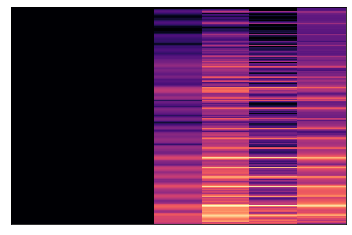

In [21]:
input_test0 = np.reshape(clean_split[0, :], (1, clean_split.shape[1]))
input_test1 = np.reshape(clean_split[1, :], (1, clean_split.shape[1]))
input_test2 = np.reshape(clean_split[2, :], (1, clean_split.shape[1]))
b1 = np.reshape(input_test0.T, (clean_split.shape[1],))
b2 = np.reshape(input_test1.T, (clean_split.shape[1],))
b3 = np.reshape(input_test2.T, (clean_split.shape[1],))
b = np.concatenate((b1, b2, b3))

c, t, Vxx_input_test = stft(b, fs=samplerate, nperseg=nperseg)
displaySpectrogram(Vxx_input_test)
plt.show()

In [22]:
def process_stft(inputs):
    return tf.math.real(tf.signal.stft(inputs, frame_length=nperseg, frame_step=nperseg))

In [23]:
def get_generator_outputs(white_split, train_size, g, nperseg, clean, clean_labels):
    rng = np.random.default_rng()
    g_outputs = []
    print("Predicting Generator Outputs")
    batch = rng.choice(white_split, train_size)
    for i in range(train_size):
        t = np.reshape(batch[i, :], (1, batch.shape[1]))
        m = g.predict(t)
        o = np.reshape(np.array(m), nperseg)
        g_outputs.append(o)
    g_outputs = np.array(g_outputs)
    labels = -1*np.ones((train_size, 1))
    input_data = np.concatenate((g_outputs, clean[:train_size,]))
    output_data = np.concatenate((labels, clean_labels[:train_size,]))
    return input_data, output_data

def show_prediction(input_test0, input_test1, input_test2, white_split, samplerate, nperseg):
    output_test0 = g.predict(input_test0)
    output_test1 = g.predict(input_test1)
    output_test2 = g.predict(input_test2)
    o1 = np.reshape(output_test0.T, (white_split.shape[1],1))
    o2 = np.reshape(output_test1.T, (white_split.shape[1],1))
    o3 = np.reshape(output_test2.T, (white_split.shape[1],1))
    o = np.concatenate((o1, o2, o3))
    c, t, Vxx_test = stft(o, fs=samplerate, nperseg=nperseg)
    displaySpectrogram(Vxx_test)
    plt.show()

In [51]:
def skip_generator(size):
    inputs = tf.keras.Input(shape=(size,))
    x0 = tf.keras.layers.Reshape((size, -1))(inputs)
    #x0 = tf.keras.layers.Dropout(0.1)(inputs)
    x1 = tf.keras.layers.Conv1D(4, kernel_size = (4,),  activation="tanh", padding="same")(x0)
    x2 = tf.keras.layers.Flatten()(x1)
    x3 = tf.keras.layers.Dense(size, activation="tanh")(x2)
    outputs = tf.keras.layers.Dense(size)(x3)
    model = tf.keras.Model(inputs=inputs, outputs=outputs, name="skip_autoencoder")
    model.summary()
    model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
    return model

def stft_discriminator(input_shape):
    inputs = tf.keras.Input(shape=input_shape)
    x0 = tf.keras.layers.Lambda(process_stft)(inputs)
    x1 = tf.keras.layers.Dense(512, activation="tanh")(x0)
    x2 = tf.keras.layers.Dense(256, activation="tanh")(x1)
    x3 = tf.keras.layers.Dense(128, activation="tanh")(x2)
    outputs = tf.keras.layers.Dense(1, activation="sigmoid")(x3)
    model = tf.keras.Model(inputs=inputs, outputs=outputs, name="discriminator")
    model.summary()
    model.compile(optimizer= 'adam', loss='mse', metrics=['accuracy'])
    return model


def GAN(size, g, d):
    z = tf.keras.layers.Input(shape=(size,))
    image = g(z)
    valid = d(image)
    d.trainable = False
    combined_network = tf.keras.Model(z, valid)
    combined_network.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
    return combined_network

g = skip_generator(clean_split.shape[1])
d = stft_discriminator(clean_split.shape[1])

Model: "skip_autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_33 (InputLayer)        [(None, 1024)]            0         
_________________________________________________________________
reshape_22 (Reshape)         (None, 1024, 1)           0         
_________________________________________________________________
conv1d_16 (Conv1D)           (None, 1024, 4)           20        
_________________________________________________________________
flatten_1 (Flatten)          (None, 4096)              0         
_________________________________________________________________
dense_8 (Dense)              (None, 1024)              4195328   
_________________________________________________________________
dense_9 (Dense)              (None, 1024)              1049600   
Total params: 5,244,948
Trainable params: 5,244,948
Non-trainable params: 0
________________________________________

In [52]:
def train_discriminator_on_batch(g, d, white, clean, clean_labels, train_size=5000, batch_num=1, max_accuracy=0.4, max_iterations=50):
    it = 0
    for _ in range(batch_num):
        previous_accuracy = 0
        input_data, output_data = get_generator_outputs(white_split, train_size, g, nperseg, clean, clean_labels)
        history = d.fit(input_data, output_data, batch_size=16)
        while previous_accuracy < max_accuracy and it < max_iterations:
            it += 1
            if abs(np.mean(history.history['accuracy']) - previous_accuracy) < 0.001:
                input_data, output_data = get_generator_outputs(white_split, train_size, g, nperseg, clean, clean_labels)
            previous_accuracy = np.mean(history.history['accuracy'])
            history = d.fit(input_data, output_data, batch_size=16)
    return np.mean(history.history['accuracy']), d

In [57]:
clean_labels = np.ones((clean_split.shape[0], ))
white_labels = np.zeros((white_split.shape[0], ))

In [58]:
print("Pre-training the generator")
g_accuracy = g.fit(white_split, clean_split, epochs=1, batch_size=16).history['accuracy'][-1]

Pre-training the generator
667/667 [==============================] - 16s 24ms/step - loss: 26114586.0000 - accuracy: 0.0065


In [59]:
print("Pre-training the discriminator")
d_accuracy = d.fit(np.concatenate((white_split, clean_split)), np.concatenate((white_labels, clean_labels)), epochs=1, batch_size=16).history['accuracy'][-1]

Pre-training the discriminator
1333/1333 [==============================] - 5s 3ms/step - loss: 0.2520 - accuracy: 0.5005


In [61]:
for i in range(3):
    print("Generator accuracy:", g_accuracy)
    print("Discriminator accuracy:", d_accuracy)
    previous_accuracy  = 0
    gan = GAN(white_split.shape[1], g, d)
    print("Training the generator")
    history = gan.fit(white_split, clean_labels, epochs=1, batch_size=16)
    new_accuracy = np.mean(history.history['accuracy'])
    it = 0
    while new_accuracy < max(g_accuracy, d_accuracy) and it < 50:
        it += 1
        previous_accuracy = np.mean(history.history['accuracy'])
        history = gan.fit(white_split, clean_labels, batch_size=16)
        new_accuracy = np.mean(history.history['accuracy'])
        if new_accuracy > d_accuracy:
            g_accuracy = new_accuracy
    #show_prediction(input_test0, input_test1, input_test2, white_split, samplerate, nperseg)
    print("Generator accuracy:", g_accuracy)
    print("Discriminator accuracy:", d_accuracy)
    print("Training the discriminator")
    #history = d.fit(np.concatenate((white_split, clean_split)), np.concatenate((white_labels, clean_labels)), epochs=3)
    d_accuracy, d = train_discriminator_on_batch(g, d, white_split, clean_split, clean_labels, max_accuracy=max(g_accuracy, d_accuracy))

Generator accuracy: 0.006473402958363295
Discriminator accuracy: 0.5004690885543823
Training the generator
667/667 [==============================] - 20s 29ms/step - loss: 0.2494 - accuracy: 0.5394
Generator accuracy: 0.006473402958363295
Discriminator accuracy: 0.5004690885543823
Training the discriminator
Predicting Generator Outputs


ValueError: all the input arrays must have same number of dimensions, but the array at index 0 has 2 dimension(s) and the array at index 1 has 1 dimension(s)

In [ ]:
i = [np.reshape(white_split[k, :], (1, white_split.shape[1])) for k in range(25)]
o = [g.predict(i[k]) for k in range(len(i))]
p = [np.reshape(i[k].T, (white_split.shape[1],)) for k in range(len(o))]
q = [np.reshape(o[k].T, (white_split.shape[1],)) for k in range(len(o))]


a = np.concatenate(p)
b = np.concatenate(q)
Audio(a, rate=samplerate)

In [ ]:
Audio(b, rate=samplerate)